# Statistical Arbitrage in ETFs

Pairs trading is a type of statistical arbitrage strategy designed to profit from the mean-reverting behaviour of a certain pair ratio. 

The assumption behind this strategy is that the spread from pairs that show properties of co-integration is mean reverting in nature and therefore will provide arbitrage opportunities if the spread deviates significantly from the mean.

In [59]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from pykalman import KalmanFilter
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

#import seaborn as sns
import ffn

## ETFs 

ETFs provide a fertile ground for finding cointegrating price series—& thus are good candidates for pair trading. In this notebook, we will use  Canadian and Australian economies which are commodity based, so they seem likely to cointegrate. Their respective ETFs are:

- EWA, iShares MSCI Australia ETF 
- EWC, iShares MSCI Canada ETF

## Dataset
Data was retrieved from CRSP via Wharton Research Data Services. Daily price data of each ETF was for the duration Jan 2010 to Jun 2018. 

In [64]:
etfs = pd.read_csv('EWA_EWC.csv', index_col='Date',parse_dates=True)
etfs.head()

,EWA,EWC
Date,,
2010-04-01,23.72,26.92
2010-05-01,23.79,27.07
2010-06-01,23.88,27.28
2010-07-01,23.77,27.19
2010-08-01,24.05,27.33


## Brief Outline

1. ETF pair will be tested for co-integration. An ADF test will be performed such that, the alternative hypothesis is that the pair to be tested is stationary.
1. Run an Augmented Dickey-Fuller test on the spread to confirm statistically whether the series is mean reverting or not. We will also calculate the Hurst exponent of the spread series.
1. Run a Kalman Filter regression on the spread series and a lagged version of the spread series in order to then use the coefficient to calculate the half-life of mean reversion.
1. Calculate Z-scores for trading signal, define enter and out Z-score level for back-testing.

## Cointegration Test via Augmented Dickey-Fuller Test

### Cointegration
If we can find a stationary linear combination of several nonstationary price series, then these price series are cointegrated. The most common combination is that of two price series: We long one asset and simultaneously short another asset, with an appropriate allocation of capital to each asset.

### Augmented Dickey-Fuller Test
The ADF test is based on the following observation: If the price level is higher than the mean, the next move will be a downward move; if the price level is lower than the mean, the next move will be an upward move. The ADF test will find out if $\lambda = 0 $. If the hypothesis $\lambda = 0 $ can be rejected, that means the next move of a price change depends on the current price level, and therefore it is not a random walk. 

ADF test will be performed such that the alternative hypothesis is that the pair to be tested is stationary. The null hypothesis will be rejected for p-values < 0.05.

In [61]:
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] # the length of dateframe
    pvalue_matrix = np.ones((n, n)) # initialize the matrix of p
    keys = dataframe.keys() # get the column names
    pairs = [] # initilize the list for cointegration
    
    for i in range(n):
        for j in range(i+1, n): # for j bigger than i
            stock1 = dataframe[keys[i]] # obtain the price of two contract
            stock2 = dataframe[keys[j]]
            result = sm.tsa.stattools.coint(stock1, stock2) # get conintegration
            pvalue = result[1] # get the pvalue
            pvalue_matrix[i, j] = pvalue
            
            if pvalue < critial_level: # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pvalue)) # record the contract with that p-value
                
    return pvalue_matrix, pairs

pvalue_matrix, pairs = find_cointegrated_pairs(etfs); print(pairs)

[('EWA', 'EWC', 0.039317951436103678)]


## Kalman Filter

Kalman filtering, also known as linear quadratic estimation (LQE), is an algorithm that uses a series of measurements observed over time, containing statistical noise and other inaccuracies, and produces estimates of unknown variables that tend to be more accurate than those based on a single measurement alone, by estimating a joint probability distribution over the variables for each time-frame. 

Because the Kalman filter updates its estimates at every time step and tends to weigh recent observations more than older ones, a particularly useful application is an estimation of rolling parameters of the data. When using a Kalman filter, there’s no window length that we need to specify. This is useful for computing the moving average if that’s what we are interested in, or for smoothing out estimates of other quantities.

In [46]:
def KalmanFilterAverage(x):
  
    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    
    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    
    return state_means


# Kalman filter regression
def KalmanFilterRegression(x,y):
    
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)
    
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    
    return state_means

In [47]:
KalmanFilterAverage(etfs.EWA)

Date
2010-04-01    11.860000
2010-05-01    15.889338
2010-06-01    17.951102
2010-07-01    19.181042
2010-08-01    20.063528
2010-11-01    20.742061
2010-12-01    21.142425
2010-01-13    21.507192
2010-01-14    21.841307
2010-01-15    22.057235
2010-01-19    22.279660
2010-01-20    22.390873
2010-01-21    22.402667
2010-01-22    22.364366
2010-01-25    22.365779
2010-01-26    22.326416
2010-01-27    22.281441
2010-01-28    22.221475
2010-01-29    22.110606
2010-01-02    22.061460
2010-02-02    22.032034
2010-03-02    21.979371
2010-04-02    21.833284
2010-05-02    21.713328
2010-08-02    21.592712
2010-09-02    21.541554
2010-10-02    21.482925
2010-11-02    21.499877
2010-12-02    21.478852
2010-02-16    21.542013
                ...    
2018-05-18    22.616197
2018-05-21    22.651755
2018-05-22    22.668711
2018-05-23    22.672638
2018-05-24    22.679046
2018-05-25    22.671527
2018-05-29    22.635234
2018-05-30    22.649005
2018-05-31    22.641490
2018-01-06    22.648958
2018-04-06 

In [48]:
KalmanFilterRegression(etfs.EWA, etfs.EWC)

array([[ 1.08544421,  1.08544421],
       [ 1.08914954,  1.08834207],
       [ 1.0925956 ,  1.09016408],
       ..., 
       [ 1.15692285,  2.31712629],
       [ 1.1530916 ,  2.31797018],
       [ 1.155231  ,  2.31734261]])

## Hurst exponent and Half-life

The Hurst exponent is used as a measure of long-term memory of time series. It relates to the auto-correlations of the time series and the rate at which these decrease as the lag between pairs of values increases.

To simplify things, the important info to remember here is that a time series can be characterized in the following manner with regard to the Hurst exponent (H):

- H < 0.5 – The time series is mean reverting
- H = 0.5 – The time series is a Geometric Brownian Motion
- H > 0.5 – The time series is trending

However just because a time series displays mean-reverting properties, it doesn’t necessarily mean that we can trade it profitably – there’s a difference between a series that deviates and mean reverts every week and one that takes 10 years to mean revert.

In [49]:
def half_life(spread):
    
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    
    if halflife <= 0:
        halflife = 1
        
    return halflife

## Backtesting

The back-test engine follows the steps:

1. Calculate Spread = Y – hedge ratio * X
1. Using Kalman Filter Regression Function to calculate hedge ratio
1. Calculate z-score of ‘s’, using rolling mean and standard deviation for the time period of ‘half-life’ intervals. Save this as z-score
1. Using half-life Function to calculate half life
1. Define upper entry Z-score = 2.0, lower entry Z-score = 2.0, exit Z-score = 0.0
1. When Z-score crosses upper entry Z-score, go SHORT; close the position with Z-score return exit Z-score
1. When Z-score crosses lower entry Z-score, go LONG; close the position with Z-score return exit Z-score

In [50]:
def backtest(s1, s2, x, y ):
    
    """ 
    INPUT:
    s1: the symbol of contract one
    s2: the symbol of contract two
    x: the price series of contract one
    y: the price series of contract two
    
    OUTPUT:
    df1['cum rets']: cumulative returns in pandas data frame
    sharpe: sharpe ratio
    CAGR: CAGR
    """
    
    # run regression to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    
    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)
    
    # calculate half life
    halflife = half_life(df1['spread'])
    
    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    ##############################################################
    # trading logic
    entryZscore = 2
    exitZscore = 0

    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore)) 
    
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0  # df1.loc['num units long', 0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad') 
    
    #set up num units short 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1
    
    name = "bt"+ s1 + "-" + s2 + ".csv"
    df1.to_csv(name)

    ##############################################################

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    ##############################################################
    start_val = 1
    end_val = df1['cum rets'].iat[-1]

    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name
    days = (end_date - start_date).days

    CAGR = round(((float(end_val) / float(start_val)) ** (252.0/days)) - 1,4)

    return df1['cum rets'], sharpe, CAGR

In [52]:
df_cumret, strat_sharpe, strat_CAGR = backtest('EWA','EWC', etfs.EWA, etfs.EWC)

/Users/jothamteo/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jothamteo/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Accumulated return of the ETF pair

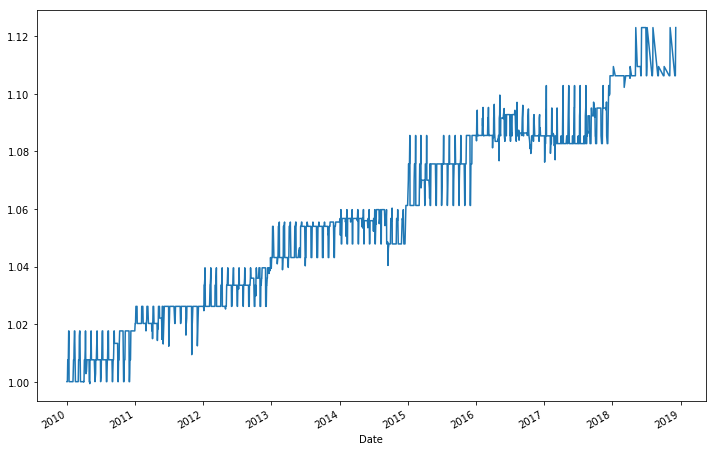

In [55]:
df_cumret.plot(figsize=(12,8))

In [57]:
strat_sharpe

0.91600476804035535

In [58]:
strat_CAGR

0.0098

The back-testing algorithm can be used to analyze the minute data, hour data of other ETFs. 

The main limitation is that the backtest has not taken slippage and trading fees into consideration.